COPY/PASTE FOR STARTER README:

## Problem Statement/Goal
Background:
    Strainprint is an app which allows you to track the effects of cannabis products on oneself.  This data is given back to the individuals such that they're able to to pay attention to how those products effect them and also aggregated by the company to pull insights about these products in larger pools of data. On [date] Strainprint published a paper on the effects of cannabis on depression, anxiety and stress as reported by their users.  They also provided the data used for these insights in their data.
    
Project Purpose:
    The purpose of my project is roughly two fold.  First I'd like to gather as much information from this data that I can.  The second purpose is to see if I can buld a model which, when fed data on a user about to ingest a cannabis product, will that model be able to accuratly predict a change within one standard error?


- Pull insights and see what I can do to predict a change.
 
 People who did the most sessions preferred which method?
 What other habits were formed by using more of the app?
 
 
 To Do:
  - Clean up EDA
  - Clean up what we have of the modeling done
  - Work on the Neural Network

## Imports

In [1]:
# Standard Imports
import pandas as pd  #df.loc[index, column]
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Model imports
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Exploritory Data Analysis

## Raw EDA

In [2]:
# Importing the data
df_anxiety    = pd.read_excel('./data/Complete Final DAS MMJ Dataset_C3D0_201804001448125278.xlsx',
                            sheet_name='anxiety')
df_depression = pd.read_excel('./data/Complete Final DAS MMJ Dataset_C3D0_201804001448125278.xlsx',
                            sheet_name='depression')
df_stress     = pd.read_excel('./data/Complete Final DAS MMJ Dataset_C3D0_201804001448125278.xlsx',
                            sheet_name='stress')

In [4]:
print(df_stress.shape)
print(df_depression.shape)
print(df_anxiety.shape)

(3717, 12)
(3151, 12)
(5085, 12)


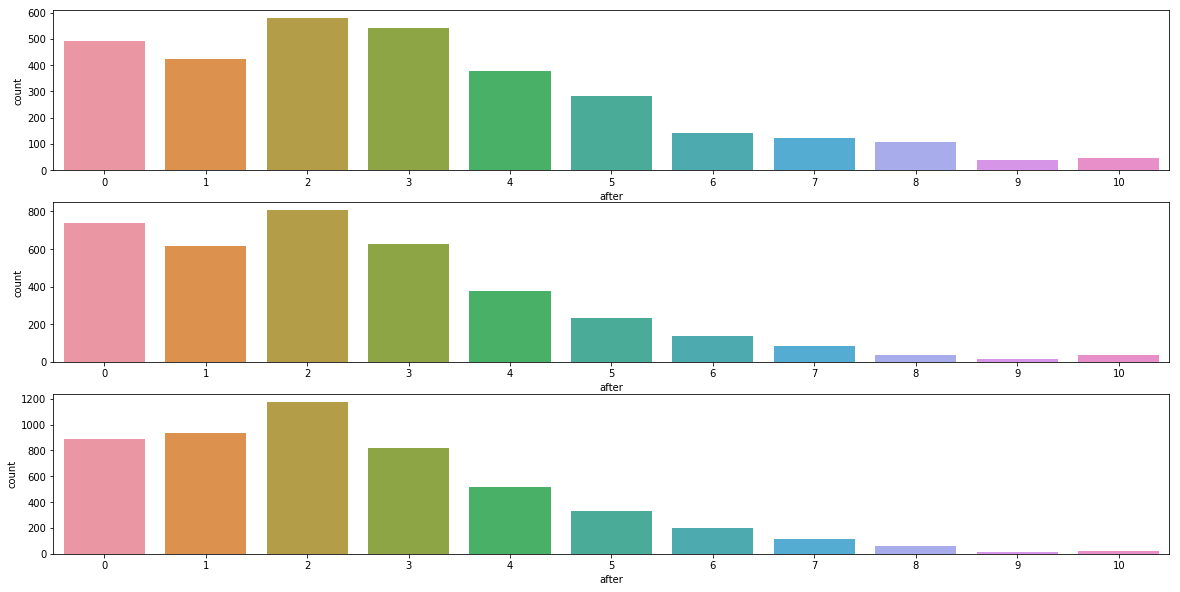

In [4]:
fig, axes = plt.subplots(3, figsize = (20,10))
sns.countplot(df_depression['after'], ax= axes[0])
sns.countplot(df_stress['after'], ax = axes[1])
sns.countplot(df_anxiety['after'], ax = axes[2]);

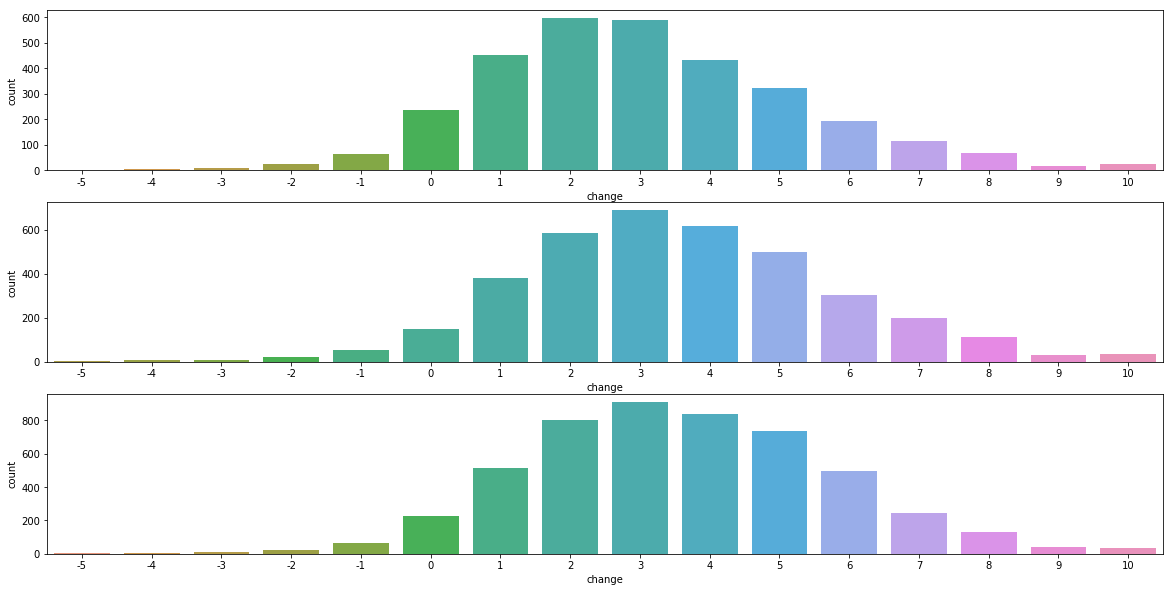

In [5]:
fig, axes = plt.subplots(3, figsize = (20,10)) # Size
sns.countplot(df_depression['change'], ax= axes[0])
sns.countplot(df_stress['change'], ax = axes[1])
sns.countplot(df_anxiety['change'], ax = axes[2]);
axes[0].set_xlim(0.5,16.5)
axes[1].set_xlim(3.5,19.5)
axes[2].set_xlim(0.5,16.5);
# Cut out a few negative outliers to better illistrate the correlation between the three graphs.

# Cleaning DF

In [6]:
df_anxiety['symptom'] = 'anxiety'
df_depression['symptom'] = 'depression'
df_stress['symptom'] = 'stress'

df_raw = pd.concat([df_depression,df_anxiety,df_stress])
df = df_raw.reset_index().drop('index', axis = 1)

# Removing data with high potential for falsely provided information
mask = df['% cbd'] >= 0  # I'm not sure of how a product could have negative amounts of something.
df = df[mask]
mask = df['% thc'] >= 0 
df = df[mask]
mask = df['age'].abs() < 90 
df = df[mask]
mask = df['time lag (min)'] <= 180 # After three hours I suspect a potential for dropped memory of the change.
df = df[mask]

# Copying these series to be used post-get_dummies.
series_method  = df['admin_method']
series_symptom = df['symptom']

df = pd.get_dummies(df)

# Reinserting the columns incase I wish to still use them in this format.
df['admin_method'] = series_method
df['symptom'] = series_symptom

# Renaming the columns to easier names.
df.rename({
    'session/time'              : 'session', # As in Session #1 or Session #2 or Session #3 for a user.
    'time lag (min)'            : "time_lag",# Time it took from initial ingestion to when effects were tracked
    '% thc'                     : 'thc_%', 
    '% cbd'                     : 'cbd_%',
    'admin_method_Concentrate'  : 'concentrate',
    'admin_method_Dab Bubbler'  : 'dab_bubbler',
    'admin_method_Dab Portable' : 'dab_portable',
    'admin_method_Smoke'        : 'smoke',
    'admin_method_Vape'         : 'vape',
    'symptom_anxiety'           : 'symptom_a',
    'symptom_depression'        : 'symptom_d',
    'symptom_stress'            : 'symptom_s',
    'admin_method'              : 'method'
}, axis = 1, inplace = True)

# Saving for safety and to make sure that this is always up to date.
df.to_csv('./data/all_symptoms_cleaned.csv', index=False)

In [7]:
df = pd.read_csv('./data/all_symptoms_cleaned.csv')

In [8]:
print('Number of users in study:', len(df['userid'].value_counts())) # (Post data cleaning)
df.describe().T

Number of users in study: 1062


,count,mean,std,min,25%,50%,75%,max
session,10065.0,16.337506,23.878303,1.00,2.0,7.00,20.0,196.0
userid,10065.0,2687.544163,1277.586521,93.00,1670.0,2717.00,3633.0,5578.0
gender,10065.0,0.514456,0.499816,0.00,0.0,1.00,1.0,1.0
age,10065.0,33.161749,9.289252,18.00,25.0,33.00,39.0,87.0
dose,10065.0,6.247789,3.044516,1.00,4.0,6.00,10.0,10.0
time_lag,10065.0,34.534903,28.122963,0.10,20.8,23.90,40.6,179.8
thc_%,10065.0,15.973149,8.993642,0.04,12.0,17.70,19.9,100.0
cbd_%,10065.0,2.980585,6.441241,0.00,0.0,0.07,1.0,99.0
before,10065.0,5.970492,2.065892,1.00,5.0,6.00,7.0,10.0
after,10065.0,2.535420,2.138061,0.00,1.0,2.00,4.0,10.0


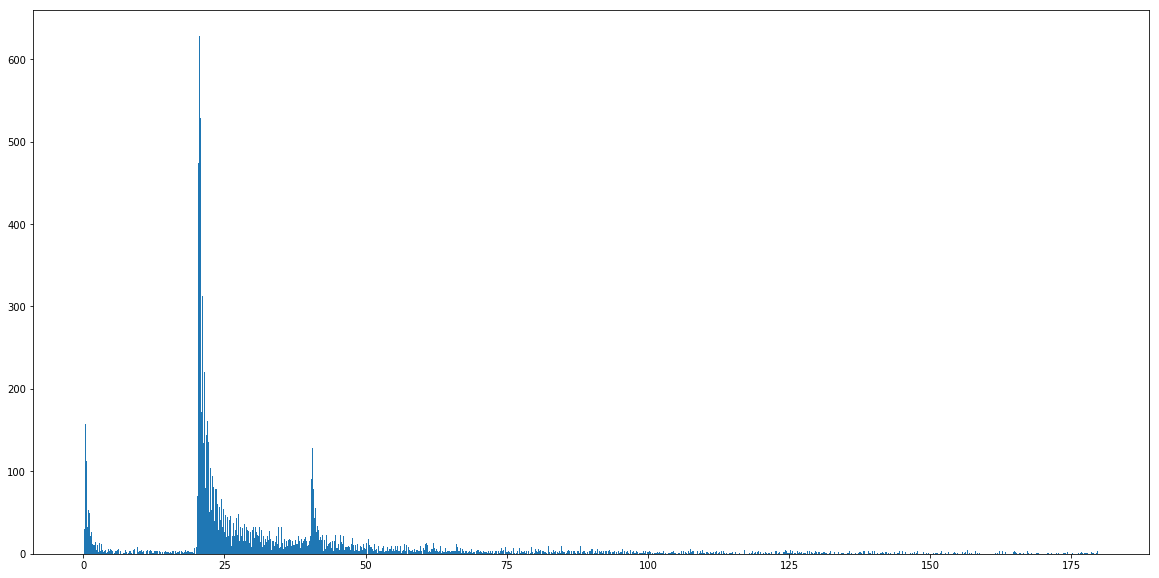

In [10]:
# Count of TIme it took people to enter in their change in symptoms.
plt.figure(figsize = (20,10))
plt.hist(df['time_lag'],bins = len(df['time_lag'].value_counts()));

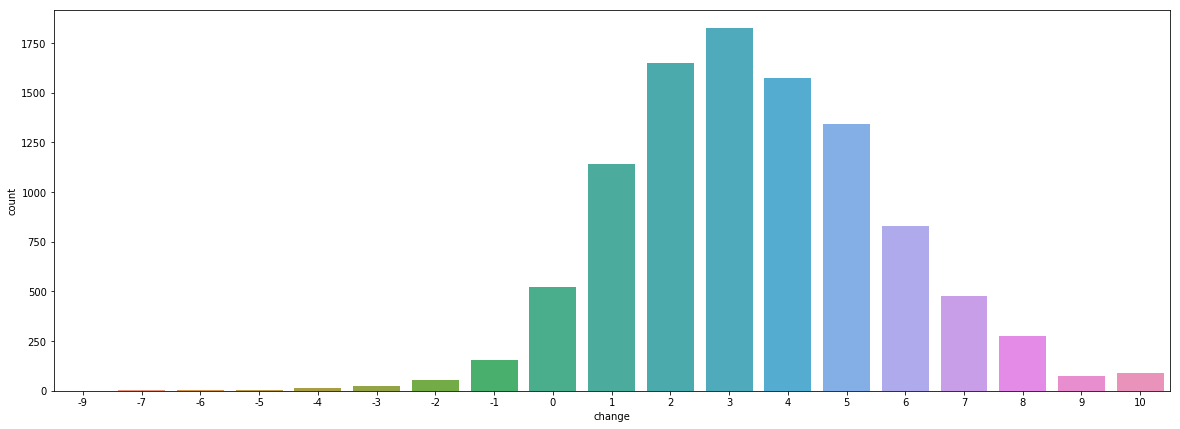

In [302]:
plt.figure(figsize=(20,7))
sns.countplot(df['change']);

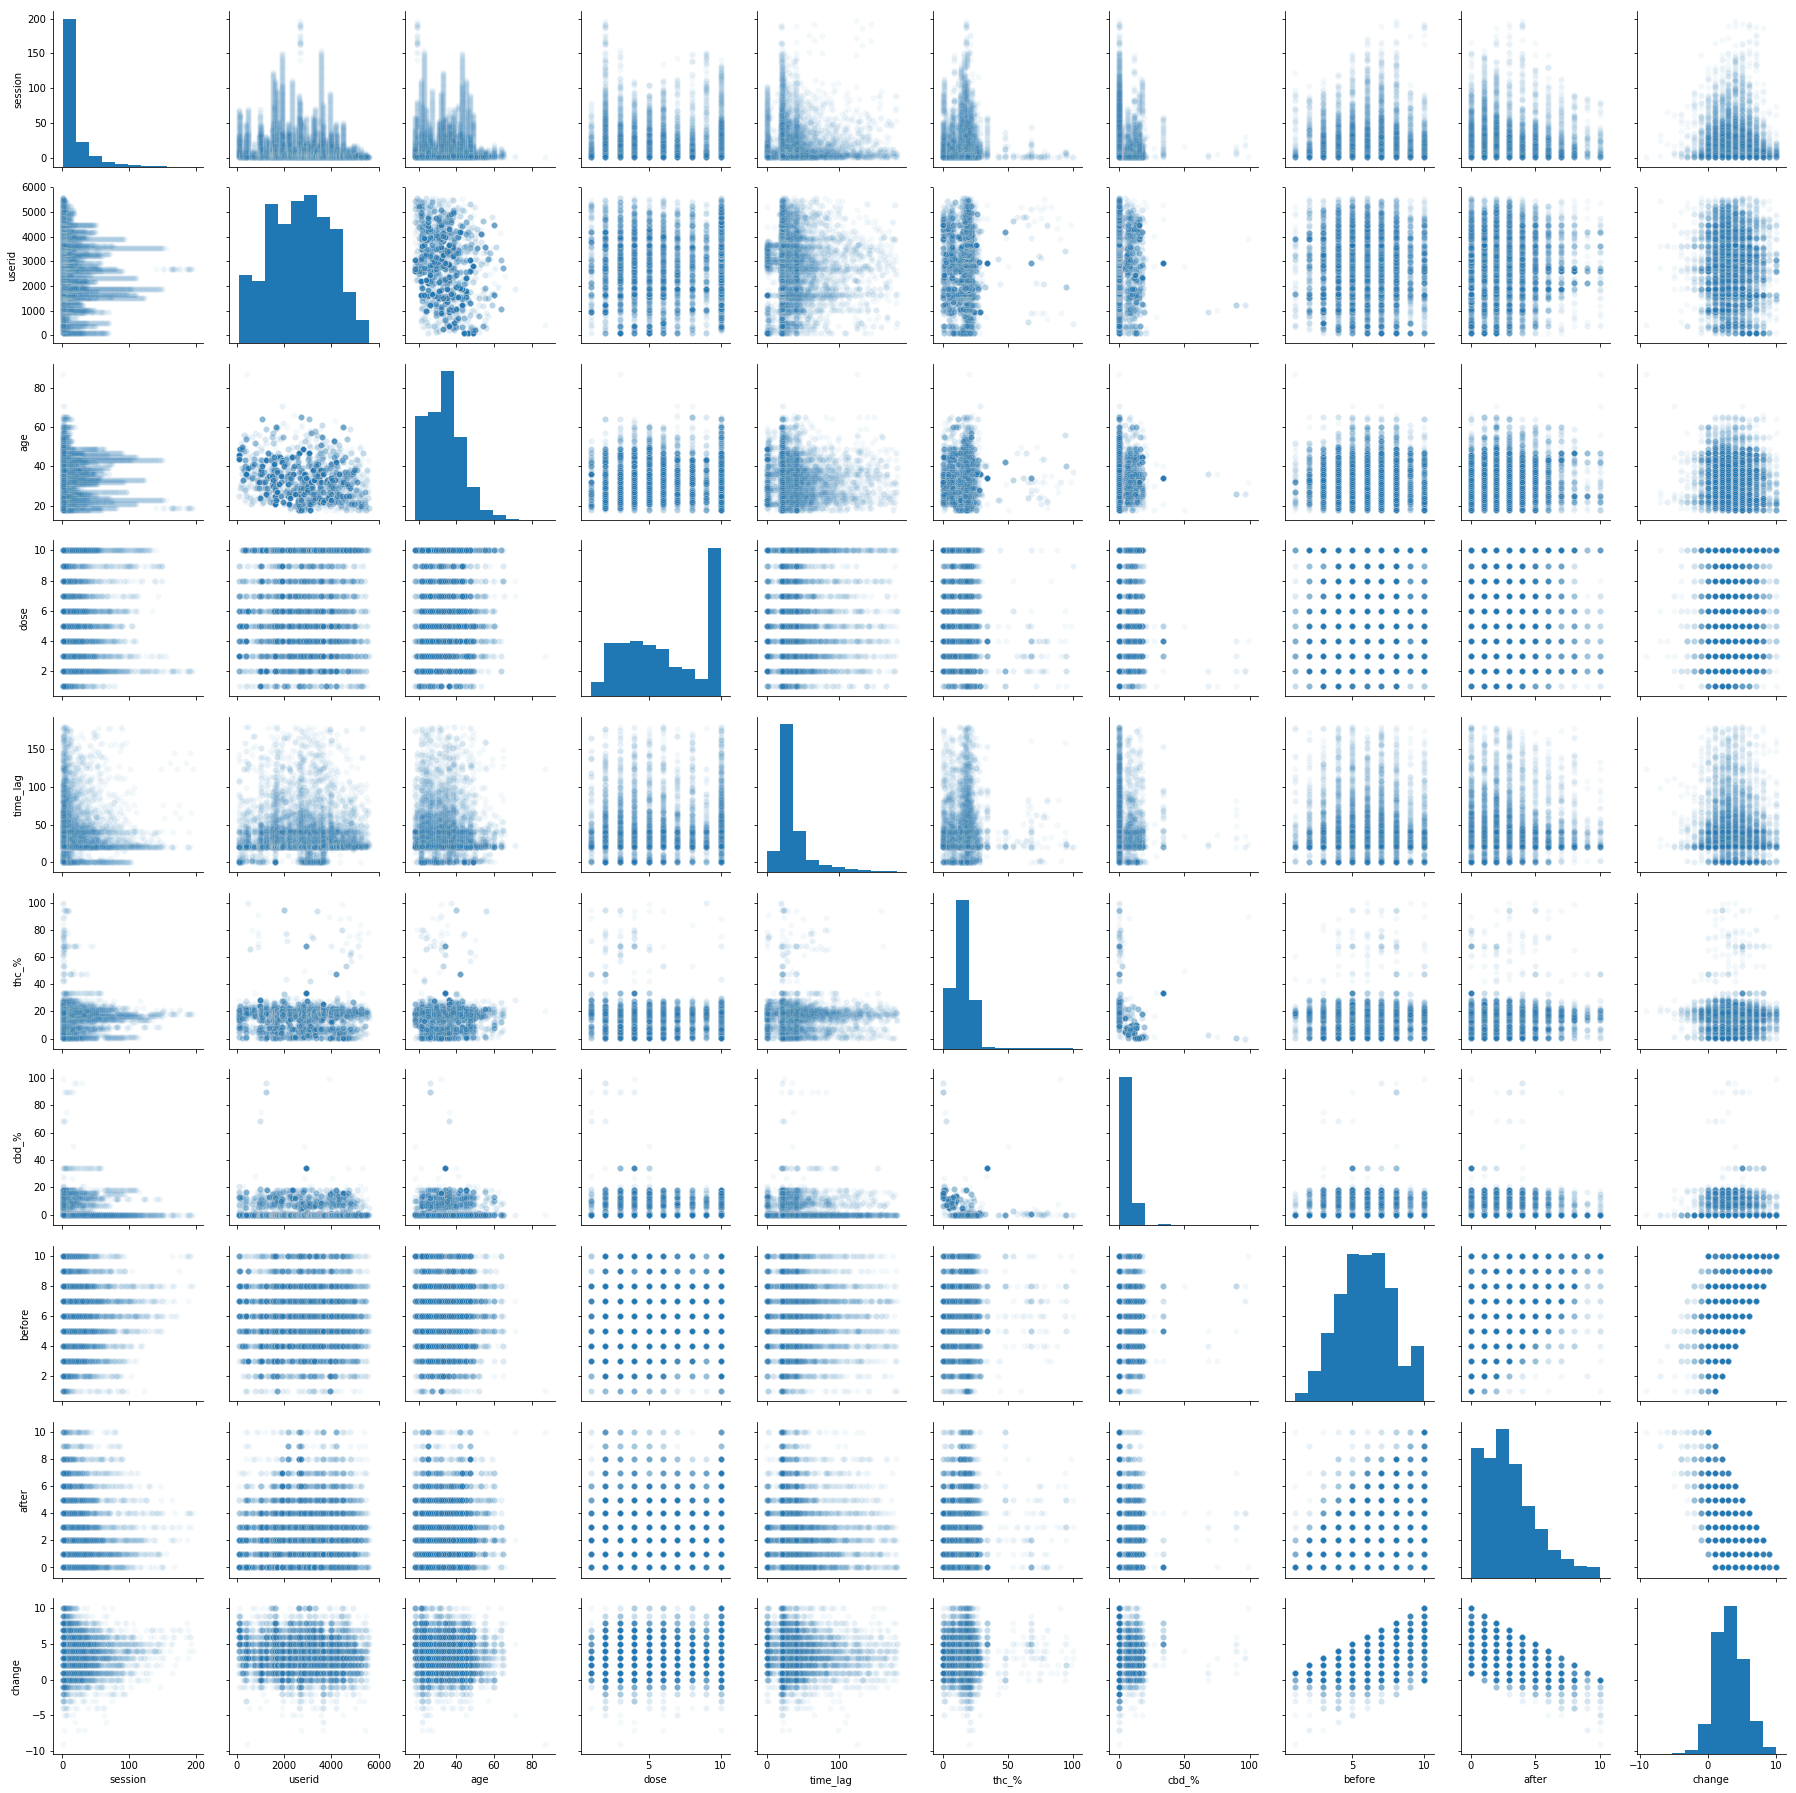

In [308]:
# Shortening the df to only the numerical data of note.
df_short = df.drop(['gender','symptom_a', 'symptom_d',
       'symptom_s', 'concentrate', 'dab_bubbler',
       'dab_portable', 'smoke', 'vape', 'symptom', 'method'], axis = 1)

sns.pairplot(df_short, plot_kws={'alpha': 0.05});

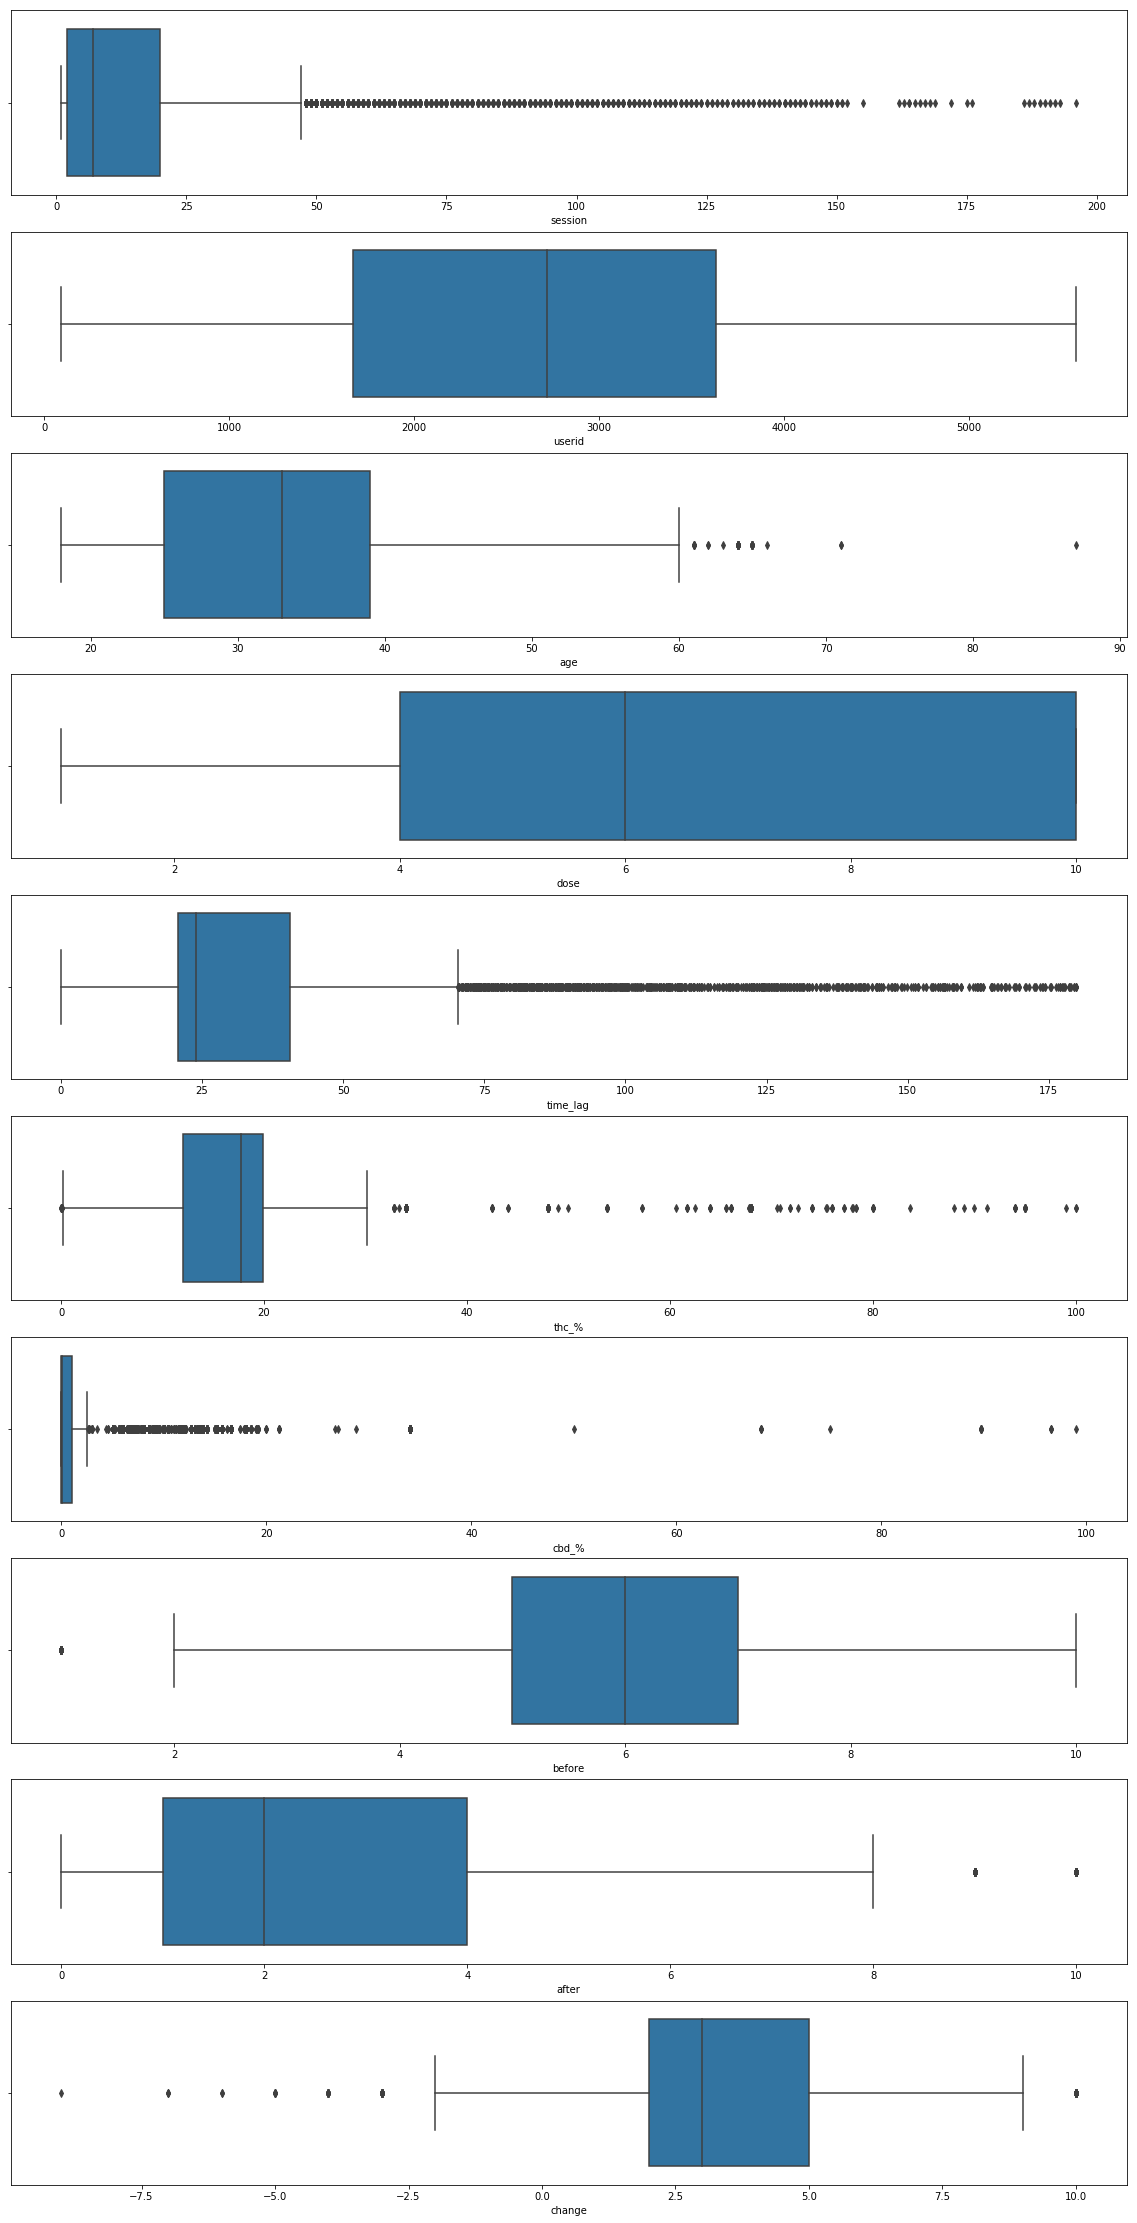

In [13]:
fig, axes = plt.subplots(len(df_short.columns),     
                   figsize = (20,40)) # Size
count = 0
for col in df_short.columns:
    sns.boxplot(df_short[col], ax = axes[count])
    count += 1

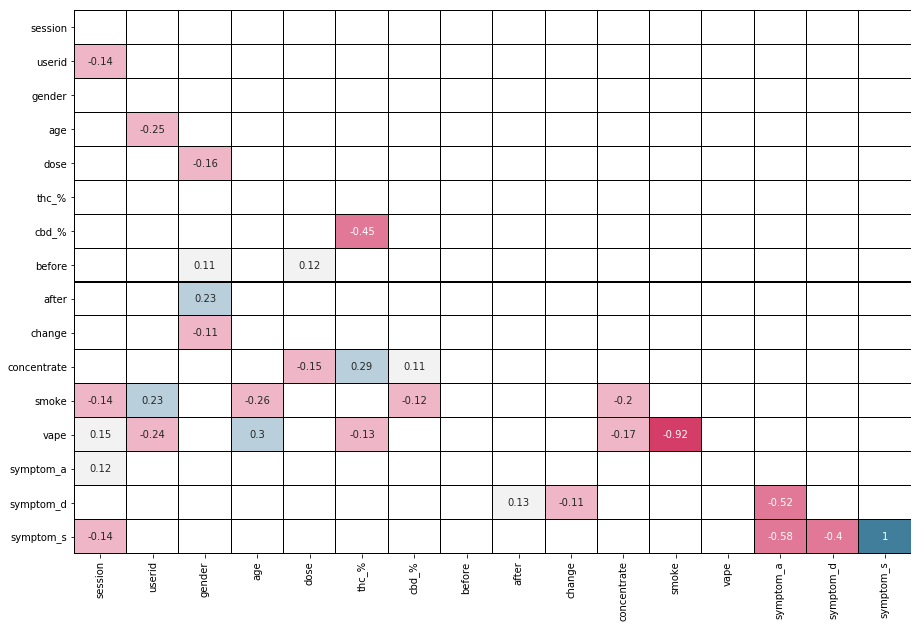

In [295]:
df_cor          = df.drop(['time_lag', 'dab_bubbler', 'dab_portable'],axis = 1).corr() 
# Dropped because nothing is signifigantly correlated to them
list_half_inner = []
list_half_outer = []

# Creating a blank-ish DF with the dementions that match the correlation matrix.
for i in range(df_cor.shape[0]):
    list_half_inner.append(True)
    list_half_outer.append(list_half_inner)
mask_half = pd.DataFrame(list_half_outer, columns= df_cor.columns, index=df_cor.columns)

# Turning it into a mask and cutting it in half.
for num in range(mask_half.shape[1]):
    mask_half.iloc[num,num:mask_half.shape[1]] = False

# Manually dropping certain values because they don't tell us anything by being correlated.
mask_half.loc['after','before'] = False
mask_half.loc['change','before':'after'] = False 

mask_half.iloc[df_cor.shape[0] - 1,df_cor.shape[1] - 1] = True
    
# Mask for limiting which correlations are shown.
mask_cor_limit = (df_cor > 0.1) | (df_cor < -0.1)
plt.figure(figsize=(15,10))

sns.heatmap(df_cor[mask_cor_limit][mask_half],
            annot = True, cbar=False, 
            linewidths= .01, linecolor='black', cmap=sns.diverging_palette(0, 230, n=7, center='light'));


In [20]:
mask = df['thc_%'] == 34
df[mask].head(20)

,session,userid,gender,age,dose,time_lag,thc_%,cbd_%,before,after,...,concentrate,dab_bubbler,dab_portable,smoke,vape,symptom_a,symptom_d,symptom_s,method,symptom
1765,2,2922,1,34,3,33.1,34.0,34.0,6,0,...,1,0,0,0,0,0,1,0,Concentrate,depression
1769,6,2922,1,34,4,20.4,34.0,34.0,8,2,...,1,0,0,0,0,0,1,0,Concentrate,depression
5910,3,2922,1,34,4,26.6,34.0,34.0,5,0,...,1,0,0,0,0,1,0,0,Concentrate,anxiety
5911,4,2922,1,34,4,20.6,34.0,34.0,6,0,...,1,0,0,0,0,1,0,0,Concentrate,anxiety
5912,5,2922,1,34,4,67.6,34.0,34.0,7,0,...,1,0,0,0,0,1,0,0,Concentrate,anxiety
5913,6,2922,1,34,5,58.4,34.0,34.0,5,0,...,1,0,0,0,0,1,0,0,Concentrate,anxiety
5914,7,2922,1,34,5,60.2,34.0,34.0,5,0,...,1,0,0,0,0,1,0,0,Concentrate,anxiety
5918,11,2922,1,34,4,93.0,34.0,34.0,5,0,...,1,0,0,0,0,1,0,0,Concentrate,anxiety
5919,12,2922,1,34,3,20.7,34.0,34.0,6,0,...,1,0,0,0,0,1,0,0,Concentrate,anxiety
5921,14,2922,1,34,4,40.9,34.0,34.0,7,0,...,1,0,0,0,0,1,0,0,Concentrate,anxiety


In [21]:
mask = (df['session'] == 6) & (df['userid'] == 2922)
df[mask]

,session,userid,gender,age,dose,time_lag,thc_%,cbd_%,before,after,...,concentrate,dab_bubbler,dab_portable,smoke,vape,symptom_a,symptom_d,symptom_s,method,symptom
1769,6,2922,1,34,4,20.4,34.0,34.0,8,2,...,1,0,0,0,0,0,1,0,Concentrate,depression
5913,6,2922,1,34,5,58.4,34.0,34.0,5,0,...,1,0,0,0,0,1,0,0,Concentrate,anxiety
10346,6,2922,1,34,4,20.4,34.0,34.0,8,0,...,1,0,0,0,0,0,0,1,Concentrate,stress


The above illistrates a concern with having shoved all three symptoms together.  While it might be easy to have dummies for if one symptom or another was being treated they might not all have the same dose, leg or % information.

## Demographic & User Insights

Q: What's correlated to churn?

TD: Add Generation lines https://www.pewresearch.org/topics/generations-and-age/

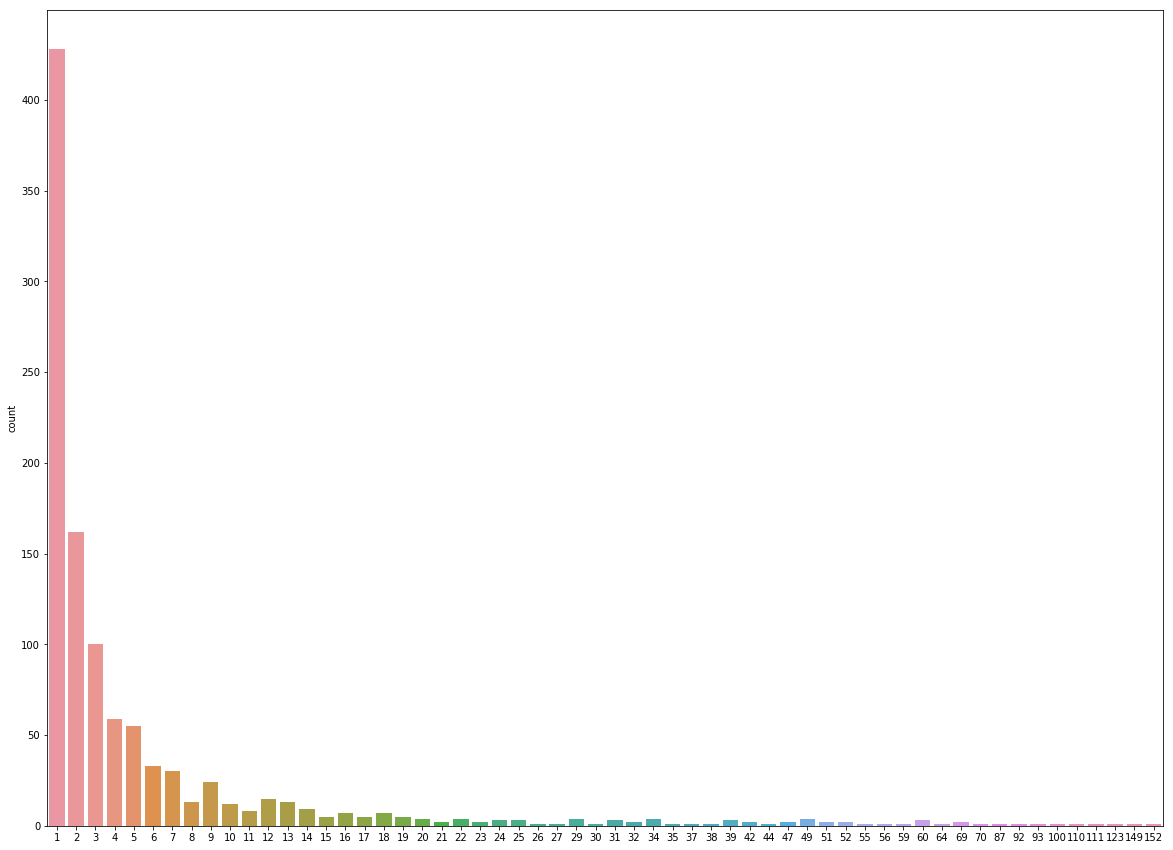

In [30]:
list_userids = []
for num in df['userid'].unique():
    mask = df['userid'] == num
    list_userids.append(len(df[mask]['session'].unique()))

plt.figure(figsize=(20,15))
sns.countplot(list_userids);

In [24]:
list_of_series = []
list_of_indexes= []
mask = df['age'].between(18, 20)
list_of_series.append(df[mask]['method'].value_counts(normalize = True))
list_of_indexes.append("18-20")

lower  = 21
higher = 25

for num in range(9):
    mask = df['age'].between(lower, higher)
    list_of_series.append(df[mask]['method'].value_counts(normalize = True))
    list_of_indexes.append(str(lower) + "-" + str(higher))
    lower  += 5
    higher += 5

    
df_age_method = pd.DataFrame(list_of_series, index=list_of_indexes)
df_age_method.fillna(0.0, inplace= True)
df_age_method['Dab'] = df_age_method['Dab Bubbler'] + df_age_method['Dab Portable']
df_age_method.drop(['Dab Bubbler','Dab Portable'], axis = 1, inplace= True)

df_age_method.to_csv('./data/age_range_and_methods.csv')
df_age_method

,Smoke,Vape,Concentrate,Dab
18-20,0.768657,0.197761,0.009328,0.024254
21-25,0.636583,0.282336,0.068050,0.013031
26-30,0.603604,0.354816,0.033957,0.007623
31-35,0.540303,0.404494,0.045921,0.009282
36-40,0.545984,0.444121,0.004657,0.005239
41-45,0.318358,0.660728,0.020914,0.000000
46-50,0.173984,0.804878,0.021138,0.000000
51-55,0.505556,0.477778,0.016667,0.000000
56-60,0.270270,0.639640,0.081081,0.009009
61-65,0.125000,0.875000,0.000000,0.000000


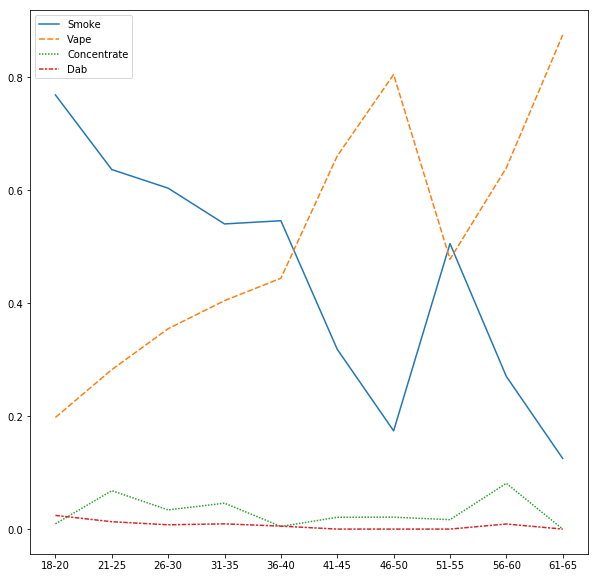

In [25]:
plt.figure(figsize= (10,10))
sns.lineplot(data = df_age_method);
# How likely one is to use an ingestion method based on age range

## Product Insights

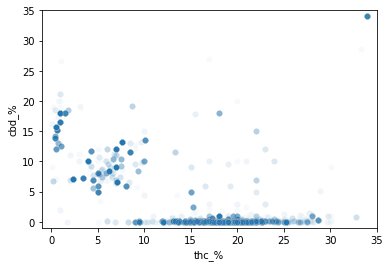

In [43]:
axes = plt.gca()
axes.set_xlim([-1,35])
axes.set_ylim([-1,35])
sns.scatterplot(df['thc_%'],df['cbd_%'],alpha=0.03);

In [65]:
pd.Series.dtype()

TypeError: 'property' object is not callable

In [69]:
df.dtypes

session           int64
userid            int64
gender            int64
age               int64
dose              int64
time_lag        float64
thc_%           float64
cbd_%           float64
before            int64
after             int64
change            int64
concentrate       int64
dab_bubbler       int64
dab_portable      int64
smoke             int64
vape              int64
symptom_a         int64
symptom_d         int64
symptom_s         int64
method           object
symptom          object
dtype: object

In [68]:
for col in df.columns:
    print(df[col].dtype)
    if df[col].dtype == 'int64' or 'float64':
        pri

int64
boop
int64
boop
int64
boop
int64
boop
int64
boop
float64
float64
float64
int64
boop
int64
boop
int64
boop
int64
boop
int64
boop
int64
boop
int64
boop
int64
boop
int64
boop
int64
boop
int64
boop
object
object


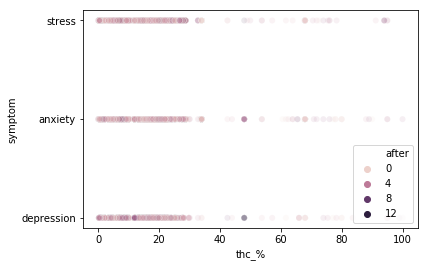

In [27]:
sns.scatterplot(df['thc_%'], df['symptom'], hue= df['after'], alpha = 0.1);

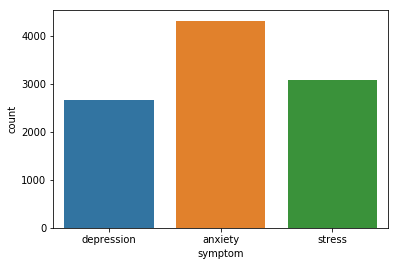

In [34]:
sns.countplot(df['symptom'])

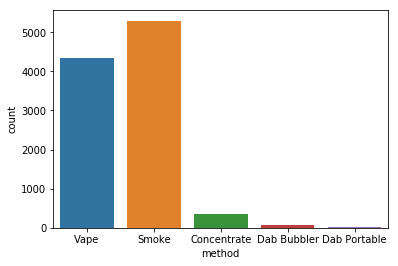

In [36]:
sns.countplot(df['method']);

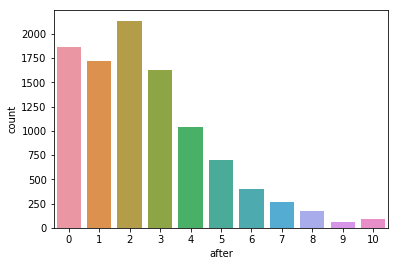

In [40]:
sns.countplot(df['after']);

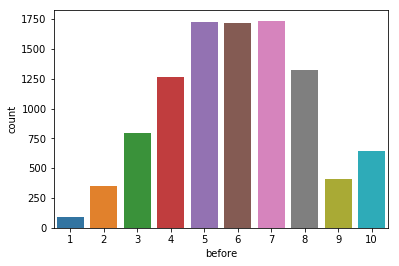

In [41]:
sns.countplot(df['before']);

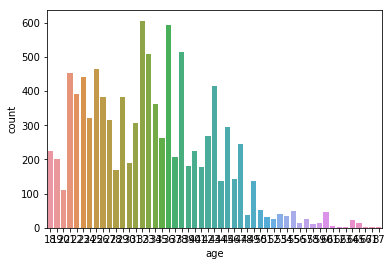

In [42]:
sns.countplot(df['age']);

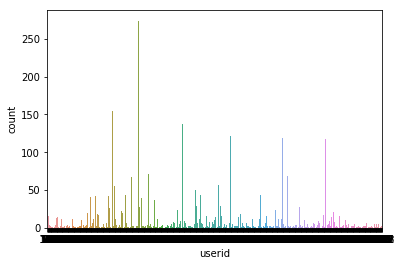

In [43]:
sns.countplot(df['userid']);

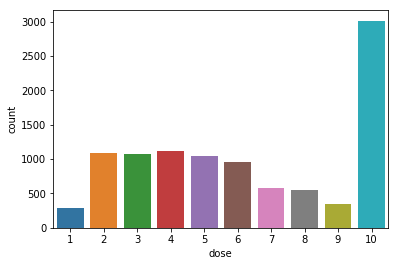

In [44]:
sns.countplot(df['dose']);

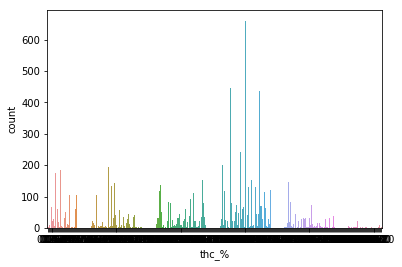

In [46]:
sns.countplot(df['thc_%']);

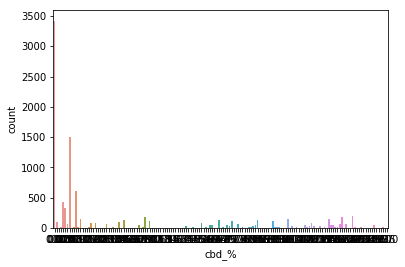

In [54]:
sns.countplot(df['cbd_%']);

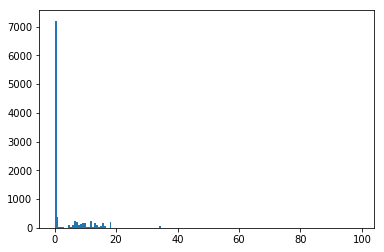

In [53]:
plt.hist(df['cbd_%'], bins= len(df['cbd_%'].unique()));

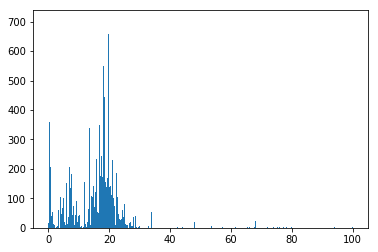

In [51]:
plt.hist(df['thc_%'], bins= len(df['thc_%'].unique()));

0.0125


0.5555555555555556

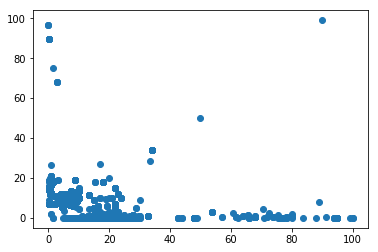

In [88]:
plt.scatter(df['thc_%'], df['cbd_%'])

In [77]:
mask = (df['vape'] == 1) & (df['vape'] == df['symptom_d'])
df[mask]

,session,userid,gender,age,dose,time_lag,thc_%,cbd_%,before,after,...,concentrate,dab_bubbler,dab_portable,smoke,vape,symptom_a,symptom_d,symptom_s,method,symptom
0,1,93,0,25,4,0.2,6.14,6.85,6,2,...,0,0,0,0,1,0,1,0,Vape,depression
1,1,97,1,46,3,0.4,15.90,0.00,6,1,...,0,0,0,0,1,0,1,0,Vape,depression
2,2,97,1,46,3,20.9,19.90,0.10,6,1,...,0,0,0,0,1,0,1,0,Vape,depression
3,3,97,1,46,3,22.3,4.50,6.90,8,0,...,0,0,0,0,1,0,1,0,Vape,depression
4,4,97,1,46,3,21.7,14.60,0.04,7,0,...,0,0,0,0,1,0,1,0,Vape,depression
5,5,97,1,46,3,20.8,17.70,0.05,6,0,...,0,0,0,0,1,0,1,0,Vape,depression
6,6,97,1,46,3,21.3,8.50,11.50,6,0,...,0,0,0,0,1,0,1,0,Vape,depression
7,7,97,1,46,2,20.8,4.50,6.90,8,1,...,0,0,0,0,1,0,1,0,Vape,depression
8,8,97,1,46,3,28.1,14.60,0.04,6,0,...,0,0,0,0,1,0,1,0,Vape,depression
9,9,97,1,46,3,21.0,17.50,0.00,9,0,...,0,0,0,0,1,0,1,0,Vape,depression


## Code Recycling Bin
- For when I'm not yet ready to delete certain old code.

In [ ]:
# Basic EDA

df.dtypes                           # Data Types of cols
df.column.unique()                  # Unique Values in col
df.describe().T                     # Summary Stats
df.info                             # Info
df['column'].value_counts(normalize=True)

In [ ]:
# Graph Alterations
# Colors: plt.colors.cnames


# For layering on top:
plt.hist(df['column_1'], color='g')
plt.hist(df['column_2'], color='b')

# For layering next to:
fig, ax = plt.subplots(2, 
                    sharex = True,  # Scale x together
                    sharey = True,    
                   figsize = (1,1)) # Size
ax[0].hist(df['column_1'],          # 
           bins = 10,               # Bins
           color='b',               # Color
           alpha = 0.5,             # Transparancy
           label = 'col_1')         # For .legend()
ax[1].hist(df['column_2'])          # 

# Labels for Words
plt.xlabel("measure",               # Alt: .ylabel
           position = (0,0),        # (x-pos, y-pos)?
           ha = 'left',             # Horizontal
           color = 'grey') # (x,y)

plt.legend()
plt.title()                         # Title ~= Subtitle
plt.suptitle("subtitle\n.",         # Subtitle
             position = (0,1),      # Position
             ha = 'left',           # Horizontal
             fontsize=16,           # Size, Font
             va = 'top');           # Vertical

In [ ]:
# List of all different graphs we have available

# WTF ARE THESE THINGS!?!?
matplotlib.Button
plt.Figure
plt.Polygon
plt.axis
plt.draw
plt.draw_if_interactive
plt.eventplot
plt.matplotlib.widgets
plt.plot_date
plt.specgram
plt.spectral # Spectral Color Map!? :D
plt.stackplot
plt.subplot
plt.table
plt.waitforbuttonpress
plt.xcorr

# Eaily usable plots
plt.boxplot
plt.hist
plt.hist2d
plt.plot
plt.scatter
plt.violinplot

sns.jointplot()
sns.pairplot()
sns.puppyplot()
sns.interactplot()
sns.countplot()

# Heatmap
plt.figure(figsize=(20,20))
sns.heatmap(df.corr(), annot=True)

# Isolating half or above a threshold heatmaps

In [18]:
for name in df.drop(['method', 'symptom'], axis = 1).columns:
    print('------------------------------------')
    print(name)
    print('')
    test = df.corrwith(df[name])
    mask = test.abs().between(0.1,0.9999)
    print(test[mask].sort_values(ascending=False))
print('------------------------------------')

------------------------------------
session

vape         0.147151
symptom_a    0.120766
userid      -0.138369
symptom_s   -0.141446
smoke       -0.142203
dtype: float64
------------------------------------
userid

smoke      0.230702
session   -0.138369
vape      -0.237709
age       -0.249398
dtype: float64
------------------------------------
gender

after     0.226095
before    0.108913
change   -0.114126
dose     -0.156066
dtype: float64
------------------------------------
age

vape      0.297020
userid   -0.249398
smoke    -0.263524
dtype: float64
------------------------------------
dose

before         0.124419
concentrate   -0.149211
gender        -0.156066
dtype: float64
------------------------------------
time_lag

Series([], dtype: float64)
------------------------------------
thc_%

concentrate    0.285345
vape          -0.128978
cbd_%         -0.451800
dtype: float64
------------------------------------
cbd_%

concentrate    0.112221
smoke         -0.119134
thc_%       